# Context

In [10]:
# Mission statement stuff

In [11]:
# My experience with both computer vision and biology

Will the stage 2 test set contain images from different image sets than stage 1 training/test?

The images to be used in the final test phase (aka, stage 2 test) on which you will be judged are generally from different experiments or cell types than those included in the stage 1 training and test data provided to you. In other words, we generally tried to hold out entire image sets for the stage 2 test, rather than holding out just individual images.

So generalizability is a key goal for your solution. 

In [7]:
# Some more context

In [8]:
# Some more context

In [9]:
# Nice things here

# EDA

This exploration starts from [this thread](https://www.kaggle.com/c/data-science-bowl-2018/discussion/47640) about image types.

**Group A** are **histological** slides, **group B** are **fluorescent** images, and **group C** are **bright-field** images. 

Based on the thread, it looks we have the following breakdown:

- fluorescent: 81.5%
- histological: 16.1%
- bright-field: 2.4%

## // Imports we'll need:

In [19]:
import numpy as np              # linear algebra
import pandas as pd             # data processing, csv files
import matplotlib.pyplot as plt # basic plotting and viz
import seaborn as sns           # pretty plotting and viz
import skimage                  # image processing in python
import os                       # miscellaneous operating system interfaces
import shutil                   # high-level operations on files and collections of files

from sklearn.preprocessing import StandardScaler # scaling data
from sklearn.cluster import KMeans               # KMeans sorting for clustering
from textwrap import wrap                        # convenience functions for strings

np.random.seed(44) # for reproducibility
%matplotlib inline

### Setting up some initial variables:

In [20]:
STAGE1_TRAIN = "./Datasets/stage1_train"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

### Functions to load the images from outside

We'll only keep the RGB (red, green, blue) channels as the Alpha channel is always empty.
> Alpha channels are used generally as an opacity layer, or specifying how a pixel's colors should be merged with another pixel when the two are overlaid, one on top of the other.

In [21]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [23]:
def read_image(image_id, space = 'rgb'):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    
    # Dropping the alpha which is not used anyways and converting hsv images
    
    image = image[:, :, :3]
    if space == 'hsv':
        image = skimage.color.rgb2hsv(image)
    return image

In [27]:
# Getting the image width, height and counting masks available

def read_image_labels(image_id, space="rgb"):
    
    image = read_image(image_id, space = space)
    
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    
    height, width, _ = image.shape
    
    num_masks = masks.shape[0]
    
    labels = np.zeros((height, width), np.uint16)
    
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 # index + 1
    
    return image, labels, num_masks

In [28]:
# Loading stage 1 image identifiers

train_image_ids = image_ids_in(STAGE1_TRAIN)

In [37]:
# Looks pretty good except for that first DS_Store element...
train_image_ids

['.DS_Store',
 '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d318

In [39]:
train_image_ids = train_image_ids[1:]

#### Run KMeans on each image. 

Centroids provide dominant colors (based on provided colorspace). This is largely based on [this blog post](https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/)

In [40]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return clt.cluster_centers_, hist

In [41]:
def get_images_details(image_ids):
    details = []
    
    for image_id in image_ids:
        image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        details.append(info)
    
    return details

In [42]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [43]:
###### Takes a while to run if not on AWS Instance: ########

details = get_images_details(train_image_ids)

## Imports:

In [1]:
import pathlib
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import ndimage

pthlib offers classes representing filesystem paths with semantics appropriate for different operating systems.

Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats.

In [2]:
# First I want to glob the training data and load a single image path

training_paths = pathlib.Path('./Datasets/stage1_train/').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

### // Dealing with color

The images in this dataset can be in RGB, RGBA and grayscale format, based on the "modality" in which they are acquired. For color images, there is a third dimension which encodes the "channel" (e.g. Red, Green, Blue). To make things simpler for this first pass, I'm going to coerce all these images into grayscale using the `rgb2gray` function from scikit-image.

In [3]:
# Original image dimensions
print('Original image shape: {}'.format(im.shape))

# Coercing the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


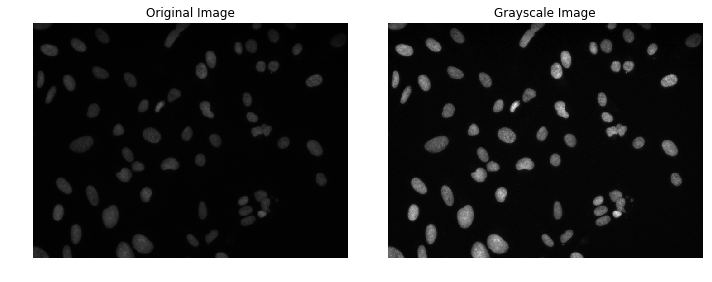

In [4]:
# Now, let's take a look at actually plotting that:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

### Removing background

The simple approach I'm going to take for this problem is to assume that there are two classes in the image: objects of interest and the background. Under this assumption, we would expect the data to fall into a bimodal distribution of intensities. If we found the best separation value, we could "mask" out the background data, then simply count the objects we're left with.

The most basic way we could find the threshold value would be to use a simple descriptive statistic, such as the mean or median. But there are other methods: the "Otsu" method is useful because it models the image as a bimodal distribution and finds the optimal separation value.

In [5]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

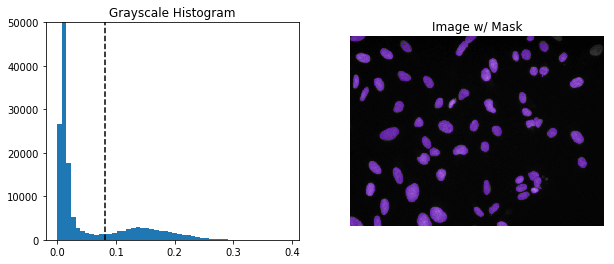

In [6]:
# Taking a look at that step visually:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

### Deriving individual masks for each object

For this contest, we need to get a separate mask for each nucleus. One way we can do this is by looking for all objects in the mask that are connected, and assign each of them a number using `ndimage.label`. Then, we can loop through each label_id and add it to an iterable, such as a list.

In [7]:
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


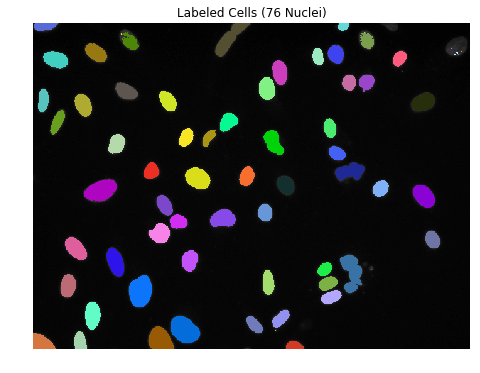

In [8]:
# Visualizing once again
# Create a random colormap

rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.figure(figsize=(8,6))
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

> A quick glance reveals a couple problems already (in this very simple image):

> - There are a few individual pixels that stand alone (e.g. top-right)
> - Some cells are combined into a single mask (e.g., top-middle and lowish right)

> Using `ndimage.find_objects`, I can iterate through the masks, zooming in on the individual nuclei found to apply additional processing steps.  `find_objects` returns a list of the coordinate range for each labeled object in the image.

In [9]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small (i.e. getting rid of those individual pixels)
    if np.product(cell.shape) < 10: 
        print('Label {} is too small, setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerating the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small, setting to 0.
Label 5 is too small, setting to 0.
Label 7 is too small, setting to 0.
Label 8 is too small, setting to 0.
Label 9 is too small, setting to 0.
Label 10 is too small, setting to 0.
Label 14 is too small, setting to 0.
Label 15 is too small, setting to 0.
Label 16 is too small, setting to 0.
Label 19 is too small, setting to 0.
Label 21 is too small, setting to 0.
Label 22 is too small, setting to 0.
Label 23 is too small, setting to 0.
Label 60 is too small, setting to 0.
Label 61 is too small, setting to 0.
Label 72 is too small, setting to 0.
There are now 60 separate components / objects detected.


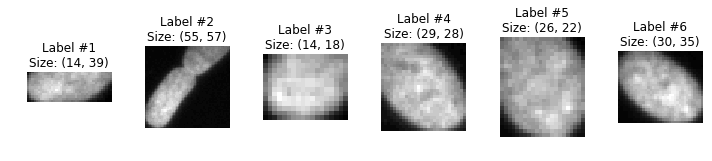

In [10]:
# Visually inspecting for additional steps that are needed

fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label #2 has the adjacent cell problem: the two cells are being considered the same object. One thing that can be done here is to see whether we can shrink the mask to "open up" the differences between the cells. This is called mask erosion. We can then re-dilate it to to recover the original proportions.

In [19]:
# Get the object indices, and perform a binary opening procedure

two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8) # Seems like 8 is going to be the smallest 
                                                                   # separation value I can get for now

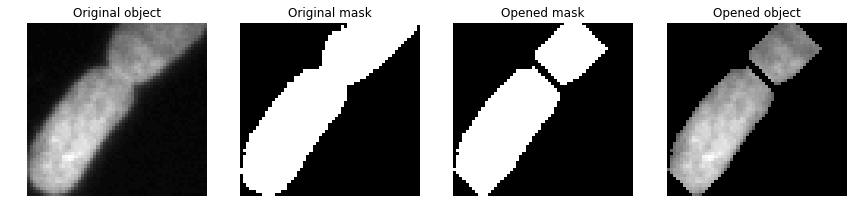

In [18]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Convert each labeled object to Run Line Encoding

Finally, we need to encode each `label_mask` into a "run line encoded" string. Basically, we walk through the array, and when we find a pixel that is part of the mask, we index it and count how many subsequent pixels are also part of the mask. We repeat this each time we see new pixel start point.

I found a nice function to do RLE from Kaggle user Rakhlin's kernel, which I've copied here.

In [20]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


## Combine it into a single function

Now that we've seen the basic steps to processing an image in a "dumb" way, we can combine it all into a single function. This function will take an image path, perform the processes outlined above, and spit out a dataframe with the RLE strings for each mask found.

We also create a wrapper function that will spit out a single DataFrame for all images in the dataset.

In [21]:
def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

###  Generating an actual (basic) submission file

In [22]:
testing = pathlib.Path('./Datasets/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission_basic.csv', index=None)